<a href="https://colab.research.google.com/github/freedom-780/A_B_test-/blob/main/Analyze_ab_test_results_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability



In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# read in the ab_data.csv and store in a dataframe
a_b = "https://raw.githubusercontent.com/freedom-780/A_B_test-/main/ab_data.csv"
df = pd.read_csv(a_b)
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

find the unique number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

find the proportion of users converted

In [5]:
df.converted.mean()

0.11965919355605512

find the number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('landing_page == "new_page" and group != "treatment"')['group'].count()

1928

find the number of rows the have missing values

In [7]:
print(f'df contains this amount of missing values {df.isnull().sum().sum()}')

df contains this amount of missing values 0


For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. Remove the conflicting rows 


In [8]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'))]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Find the unique **user_id**s in **df2**

In [10]:
df2['user_id'].nunique()

290584

find the duplicated values of **user_id** in **df2**

In [11]:
df2[df2['user_id'].duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

In [12]:
df2.duplicated().sum().sum()

0

find the row information for the repeat **user_id**

In [13]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**

In [14]:
df2.drop_duplicates(subset='user_id', inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
# check to see is duplicate values were removed
df2.duplicated().sum().sum()

0

What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control = df2.query('group == "control"')['converted'].mean()

Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment = df2.query('group == "treatment"')['converted'].mean()

In [19]:
obs = treatment - control

In [20]:
print(obs)

-0.0015782389853555567


What is the probability that an individual received the new page?

In [21]:
df2[df2['landing_page'] == "new_page"]['landing_page'].count() / df2.shape[0]

0.5000619442226688

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  
 

We want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?

$H_{0}: p_{new} \leq p_{old}$

$H_{1}: p_{new} > p_{old}$

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


Find the **convert rate** for $p_{new}$ under the null

In [22]:
p_new = df2['converted'].mean()
print(p_new)

0.11959708724499628


Find the **convert rate** for $p_{old}$ under the null <br><br>

In [23]:
p_old = df2['converted'].mean()
print(p_old)

0.11959708724499628


Find $n_{new}$

In [24]:
n_new = df2.query('group == "treatment"')['landing_page'].count()
print(n_new)

145310


Find $n_{old}$

In [25]:
n_old = df2.query('group == "control"')['landing_page'].count()
print(n_old)

145274


In [26]:
p_new-p_old

0.0

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted=np.random.choice([0,1],size=n_new, p=[1-p_new,p_new])
print(new_page_converted)

[0 0 0 ... 0 0 0]


Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.choice([0,1],size=n_old, p=[1-p_old,p_old])
print(old_page_converted)

[0 0 0 ... 0 0 0]


Find $p_{new}$ - $p_{old}$ for the simulated values

In [29]:
new_page_converted.mean() - old_page_converted.mean()

-0.0008073536606608978

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [30]:
p_diffs = []

for x in range(10000):
    boot_samp = df2.sample(df2.shape[0], replace=True)
    p_new = boot_samp['converted'].mean()
    p_old = boot_samp['converted'].mean()
    n_new = boot_samp.query('group == "treatment"')['landing_page'].count()
    n_old = boot_samp.query('group == "control"')['landing_page'].count()
    new_page_converted=np.random.choice([0,1],size=n_new, p=[1-p_new,p_new]).mean()
    old_page_converted = np.random.choice([0,1],size=n_old, p=[1-p_old,p_old]).mean()
    p_diffs.append(new_page_converted - old_page_converted)
    

In [31]:
p_diffs = np.array(p_diffs)

Plot a histogram of the **p_diffs**

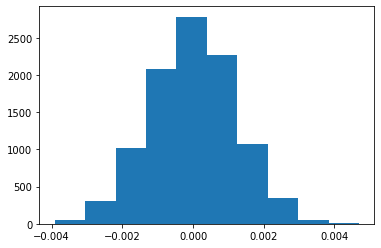

In [32]:
plt.hist(p_diffs);

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [33]:
(p_diffs > obs).mean()

0.9031

I computed the the null distribtion assume that the null hypothesis is true, which is that the p_new - p_old = 0 and by taking random samples of the dataset and randomising the converted values 10,000 times.

In this case, since the p-value is close the .5 we would fail to reject the null hypothesis that we assumbed to be true. Also from a practical standpoint, the observed values is very cose to 0 and the bootstraped distribution is too, so it is probable there is not real difference between p_new and p_old and not due to random chance. 

Calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('group == "control"')['landing_page'].count()
n_new = df2.query('group == "treatment"')['landing_page'].count()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [35]:
df2.query('group == "treatment"')['converted'].sum()

17264

In [36]:
print(convert_old)

17489


In [37]:
print(convert_new)

17264


Use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [38]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new],[n_old, n_new], alternative='smaller')

In [39]:
print(z_score)

1.3109241984234394


In [40]:
print(p_value)

0.9050583127590245


So before the test, it was agreed that alpha equals .05 significants level, this corresponds to a z score of 1.96 standard deviations above the porportion of the old treatment(using a standard normal distribution. Since a z scorce of 1.31 < 1.96 we fail to reject the null hypothesis which is that the new porportion > old portion. This means that that is different is in line with random chance and not significant.

The p-value is calculated from the z value. The P-value is the probability of observing a sample statistic as extreme as the test statistic(which is the difference in porportions). Since the probability of getting a difference as extreme as this is %90.5 it can be said that this isn't a unique result, but due to random chance. 

These conclusions agree with the boostraping method. 

<a id='regression'></a>
### Part III - A regression approach

In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion,this regression should use logistic regression since there are only two outcomes conversion or no conversion

The goal is to use **statsmodels** to fit the regression model you specified above to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [41]:
# set intercept and dummy variables

df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [42]:
# check to see if columns were added correctly 
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Use **statsmodels** to import the regression model.  Instantiate the model, and fit the model using the two columns created in part **b.** to predict whether or not an individual converts

In [43]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Provide the summary of your model below, and use it as necessary to answer the following questions.

In [44]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-01-14 20:01 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

The p value is .1882 with means you can't reject the null hypothesis which is that the coefficient is 0. This means the treatment type has no effect on the number converted.

and the null hypothesis is that ab_page does not have an impact on the odds of the converted being 1 and the alternative hypothesis is that there is an impact on converted being 1.

The null hypothesis of the other models is that the difference in sample means (for the new and old converted values) are zero and the alternative, that the mean of the new converted > old converted. 

The difference is that in Part I and Part II we are interested in seeing whether getting a different as extreme as what was observed was significant or random chance. In Part III we can see whether the control or treatment improves the odds of converting or not (the dependent variable).


Other factors were considered because you might miss other factors that can impact the odds of converted that may be hidden and correlated with other predictors and it may fit the data best. The disadvantage to adding other factors to your model is that it can overfit the model with not be able to predict future outcomes using test data accurately.

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows. 


In [45]:
countries_df = pd.read_csv('https://raw.githubusercontent.com/freedom-780/A_B_test-/main/countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [46]:
# there are three country types so you need 2 dummy columns

df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [47]:
# Create the necessary dummy variables
df_new['US'] = pd.get_dummies(df_new['country'])['US']
df_new['UK'] = pd.get_dummies(df_new['country'])['UK']


In [48]:
# Fit Your Linear Model And Obtain the Results

log_mod = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US','UK']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-01-14 20:02 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

In [49]:
# need to do the exponetial of the log-odds to get the odds ratio
np.exp(results.params)

intercept    0.131332
ab_page      0.985168
US           1.041599
UK           1.051944
dtype: float64

In [50]:
# ab_page is negative so need the resiprical of the previous results

1/_

intercept    7.614303
ab_page      1.015056
US           0.960062
UK           0.950621
dtype: float64

We would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model, the summary results, and conclusion.

In [51]:
# Set the interaction column between page and countries 

df_new["ab_US"] = df_new["ab_page"] * df_new["US"]
df_new["ab_UK"] = df_new["ab_page"] * df_new["UK"]


In [52]:
# run the logistic regression and produce a summary of the results

log_mod = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US','UK','ab_US','ab_UK']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-01-14 20:02 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
ab_US          0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
ab_UK          0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

So, we can conclude from the logistic regression that ab_page and country or not good predictors -- given the current data of the converted values due to their high p-values which means that we fail to reject the null hypotheses that the regression coefficients are zero, meaning that these predictors do not contribute to the number of converted.

ab_US and ab_UK also have high p-values meaning that we fail the reject the null hypothesis which is that there is no interaction between the countries and ab_page. This means that converted does not depend on ab_page and country. 


<a id='conclusions'></a>
## Conclusions

Throughout this project the main idea was trying to find if there was a significant difference between the treatment and control, meaning can values as extreme as observed be obtained by change or not assuming that the null hypothesis is true. The null hypothesis for the first two parts were that the difference between the treatment and control was equal to zero. 

In part one the null distribution was simulated using bootstrapping of the observed mean of data 10,000 times. In the second part the portion z test was used the assumes normality. From both parts, there was a high p value of .90 meaning that the difference between the control and treatment can be obtained from random chance, so there is no significant difference.

In the last part logistic regression since the dependent variable converted is only 0 or 1. The two predictors ab_page and U.S. have large p-values, so they don't influence the number of converted. This means that the treatment type or country are not a predictor of the number of converted, given the current data. There is also no interaction between countries and the types of pages and countries based on the high p-values.

**Therefore, it is recommended that the company continue their testing if there is enough time, or look at different predictors like click through rate or duration on a given page and let these results inform them on a different design, then retest.**

